시청률+코스닥 파일의 위치는 Baseline과 같은 곳에

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 행 많이보기
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 한글 폰트 설정
fm.get_fontconfig_fonts()

# fname 옵션을 사용하는 방법
font_location = 'C:\\WINDOWS\\Fonts\\\x7f\x7f\x7f\x7f.TTF' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=12)
plt.figure(figsize=(20,10))

# 지수 표현 안보기

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

## 기본 데이터

In [2]:
# 데이터 로드
data = pd.read_excel('./Data/2019_data_time.xlsx', encoding='cp949', header=0, parse_dates=["방송일시"])

## kosdaq데이터

In [3]:
name='kosdaq19.01.01_20.08.17(일)'
d=pd.read_excel('./Data/'+name+'.xls',index_col='일자')
kosdaq_day=d.reset_index()

In [4]:
temp=[]
from datetime import datetime
for i in range(len(kosdaq_day)):
    temp.append(datetime.strptime(kosdaq_day['일자'][i], '%Y/%m/%d'))

kosdaq_day['일자_datetime']=temp

kosdaq_day['year']=kosdaq_day['일자_datetime'].apply(lambda x: x.year)
kosdaq_day['month']=kosdaq_day['일자_datetime'].apply(lambda x: x.month)
kosdaq_day['date']=kosdaq_day['일자_datetime'].apply(lambda x: x.day)

In [5]:
kosdaq_day_19=kosdaq_day[kosdaq_day['year']==2019]
kosdaq_day_20=kosdaq_day[kosdaq_day['year']==2020]

In [6]:
#kosdaq_day_19=kosdaq_day_19['']
kosdaq_day_19=kosdaq_day_19[['현재지수','year','month','date']]

# 전처리

In [7]:
# 무형 제거
data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)



# 판매단가, 취급액 쉼표 제거 , int 변환

# data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
# data['취급액'] = data['취급액'].str.replace(',','').astype(int)
# data['노출(분)'] = data['노출(분)'].astype(int)



# 취급액 결측치 값 변경
# df.loc[df['취급액']==1]['취급액'] = 50000


# 날짜 변경 ( 다음날 데이터를 현재 날짜로 할 건지 )
# data 의 colname 영어로 변경
# index drop 필요
print(data.columns)
data.columns = ['index', 'time', 'exposure_time', 'mcode', 'product_code', 'product_name', 'category','price','salesAMT']
print(data.columns)
                
# M', 'D', 'day', 'H', 'm',
#3
data['yy-mm-dd']=data['time'].apply(lambda time:str(time).split(' ')[0])
data['s-hh-mm']=data['time'].apply(lambda time:str(time).split(' ')[1])
data['s-hh-mm']=data['s-hh-mm'].apply(lambda x: x.split(':')[0]+":"+x.split(':')[1])
data['f-hh-mm']=data['s-hh-mm']

# 끝난 시각 만들기
finishtime=[]
for i in range(len(data)):
    wdate=data.iloc[i,9]#년-월-일
    wstime=data.iloc[i,10]#s-hh-mm
    wduring=data.iloc[i,2]#exposure_time
    
    plushour,finishmin=divmod(int(wstime.split(':')[1])+int(wduring),60)#분끼리 더해서 60을 넘으면, 시간으로 반올림
    finishhour=int(wstime.split(':')[0])+int(plushour)
    #a,finishhour=divmod(finishhour,24)#24==0 바꾸는 작업
    
    finishtime.append('{0:02d}'.format(finishhour)+':'+'{0:02d}'.format(finishmin)) #2.6이상
data['f-hh-mm']=finishtime

data['year']=data['time'].apply(lambda time:time.year)
data['month']=data['time'].apply(lambda time:time.month)
data['date']=data['time'].apply(lambda time: time.day)

data['hour']=data['time'].apply(lambda time:time.hour)
data['minute']=data['time'].apply(lambda time:time.minute)

data['dayofweek']=data['time'].apply(lambda time:time.dayofweek) # Monday=0, Sunday=6.

Index(['index', '방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액'], dtype='object')
Index(['index', 'time', 'exposure_time', 'mcode', 'product_code',
       'product_name', 'category', 'price', 'salesAMT'],
      dtype='object')


In [8]:
data=pd.merge(data, kosdaq_day_19, # merge할 DataFrame 객체 이름
             how='left', # left, rigth, inner (default), outer
             on=['year','month','date'] # merge의 기준이 되는 Key 변수
        )

[datetime으로 내일_어제_쉽게구하기](https://ourcstory.tistory.com/99)

import datetime
data['time']+datetime.timedelta(days=1)

hours, minutes도 days처럼 할 수 있음.

[fillna 앞방향으로 채우기, 뒤방향으로 채우기](https://rfriend.tistory.com/262)

* 앞 방향으로 채우기

fillna(method='ffill' or 'pad')

* 뒤 방향으로 채우기 

fillna(method='bfill' or 'backfill')

In [9]:
# 앞 방향으로 채우기_ 폐장한 거 유지되기에

data['현재지수'].fillna(method='ffill',inplace=True)

# 2019년1월1일을 채우기 위해 2018년 12월 31일을 보았지만 역시 휴일이었기에 12월28일 주가 넣음: 675.65
data['현재지수'].fillna(675.65,inplace=True)

In [10]:
#data.to_excel('./Data/일별코스닥.xlsx')

# kosdaq 일별 그래프 그려보기
예민-> 소비심리 반영?-> 소비지수, 물가지수, 신용카드 사용액에 대한 경기 분석을 통해. 이자율


* 선행경기지표-> 경기가 나빠지기 전에 먼저 나빠지는 경우
* 동행경기지표-> 비슷하게
* 후행경기지표


2019-01-01~2020-08-15
* 국내 첫 감염 || 2020-01-20
* 신천지(그룹감염1차)||2020-02-20
* WHO에서 팬더믹 선언 || 2020-03-11
* 사회적거리두기 첫시행 || 2020-03-22


In [11]:
kosdaq_day.set_index('일자_datetime',inplace=True)

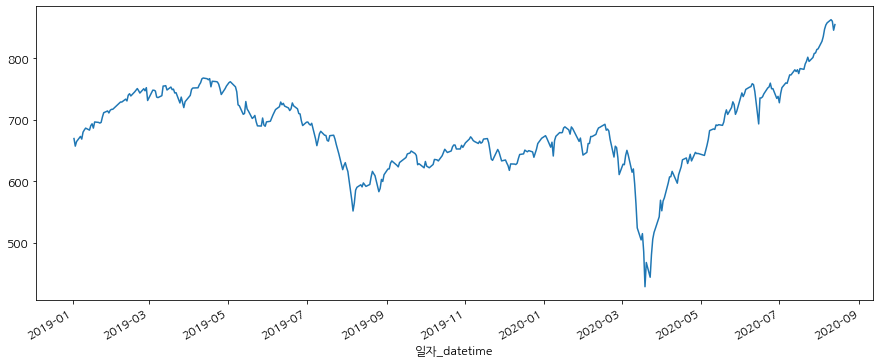

In [12]:
f,axes=plt.subplots(1,1,figsize=(15,6),sharex=True)
kosdaq_day['현재지수'].plot()

In [13]:
kosdaq_day['현재지수'].sort_values()
# 가장 낮은 때가 3월19일 

일자_datetime
2020-03-19    428.35
2020-03-23    443.76
2020-03-20    467.75
2020-03-24    480.40
2020-03-18    485.14
2020-03-16    504.51
2020-03-25    505.68
2020-03-17    514.73
2020-03-26    516.61
2020-03-27    522.83
2020-03-13    524.00
2020-03-30    542.11
2019-08-06    551.50
2020-04-01    551.84
2020-03-12    563.49
2019-08-07    564.64
2020-04-02    567.70
2020-03-31    569.07
2019-08-05    569.79
2020-04-03    573.01
2019-08-26    582.91
2019-08-08    585.44
2019-08-27    588.32
2019-08-09    590.04
2019-08-13    590.75
2019-08-16    591.57
2019-08-12    594.17
2019-08-19    594.65
2020-03-11    595.61
2020-04-13    596.71
2019-08-14    597.15
2020-04-06    597.21
2019-08-29    599.57
2019-08-28    602.90
2020-04-07    606.90
2019-08-20    607.01
2020-04-08    607.37
2019-08-23    608.98
2020-04-14    610.29
2019-08-30    610.55
2020-02-28    610.73
2020-04-10    611.26
2019-08-22    612.25
2020-03-09    614.60
2019-08-02    615.70
2020-04-09    615.95
2019-08-21    615.96
2